In [520]:
from ogs6py import ogs
import os
import ogs6py
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import math
from types import MethodType
import pandas as pd
from pathlib import Path
import shutil

pi = math.pi
%matplotlib inline
plt.rcParams['text.usetex'] = True

# Great Cell - 3D

<!-- ![Benchmarking idea](./figures/greatcell_benchmarking.png "Benchmarking idea.") -->


<img src="./figures/mechanical_3d.png#one-half" alt="Benchmarking idea." style="width:300px;">

<div style="display: flex;">
  <img src="./figures/YoungModulus_2D.png" alt="Young's modulus and Poisson's ratio for the main sample and rubber sheath" style="width:400px;">
  <img src="./figures/model_3D.png" alt="Schematic view of 3D model" style="width:400px;">
</div>

### Path

In [558]:
fracture_angle = 0 #  use angle colockwise - 3:00 O'clock is 0 deg #78.75 #112.5

In [559]:
prj_path='./'
results_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not results_dir.exists():
    results_dir.mkdir(parents=True)
        
mesh_path = "mesh_0"     

In [733]:
def update_mesh_path_in_xml(prj_path, prj_name, mesh_path):
    """
    Updates the mesh path in an XML file located at a given project path and project name.

    Parameters:
    - prj_path: The path to the directory containing the project file.
    - prj_name: The name of the project file to be modified.
    - mesh_path: The new name to replace the mesh folder part in the <mesh> tags.
    """
    original_file_path = f"{prj_path}/{prj_name}"
    copied_file_path = f"{results_dir}/{prj_name}"

    shutil.copy(original_file_path, copied_file_path)

    with open(copied_file_path, 'r') as file:
        file_content = file.read()

    new_content = file_content.replace('<mesh>mesh/', f'<mesh>{mesh_path}/')

    with open(copied_file_path, 'w') as file:
        file.write(new_content)

    print(f"The mesh folder added in prj file and modified successfully. Modified file saved to {copied_file_path}")


In [579]:
def get_paths(case, mesh_path): # using VPF process
    prj_name = "great_cell_3d.prj"
    ogs_path = "~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs" #
    
    if case in ['M1_triaxial', 'M1_axisymmetric', "M1_triaxial_differentMaterial", "M1_axisymmetric_differentMaterial"]: # using SD process
        prj_name = "great_cell_3d_SDprocess.prj"
        ogs_path = "~/master_test/build_master_modifiedE/bin/ogs" 
        
    update_mesh_path_in_xml(prj_path, prj_name, mesh_path)
    return ogs_path, prj_name

## Definition of functions

### Set Young's modulus and Poisson's ratio for the main sample and rubber sheath


<!-- <div style="display: flex;">
  <img src="./figures/YoungModulus_2D.png" alt="Young's modulus and Poisson's ratio for the main sample and rubber sheath" style="width:400px;">
  <img src="./figures/model_3D.png" alt="Schematic view of 3D model" style="width:400px;">
</div> -->

In [581]:
def set_E_nu(in_m, out_m,young_sample,nu_sample,young_sheath, nu_sheath):
    m = pv.read(f'{prj_path}/{mesh_path}/{in_m}')
    n_cells = m.n_cells
    
    young = np.zeros(n_cells)
    nu = np.zeros(n_cells)

    for i in range(n_cells):
        cell = m.GetCell(i)
        x_min,x_max,y_min,y_max,z_min,z_max = cell.GetBounds()
        
        x = (x_min+x_max)/2
        y = (y_min+y_max)/2
        if (x**2 + y**2) > 0.097**2:
            young[i] = young_sheath
            nu[i] = nu_sheath
        else:
            young[i] = young_sample
            nu[i] = nu_sample

    m.cell_data['E'] = young
    m.cell_data['nu'] = nu

    m.save(f'{prj_path}/{mesh_path}/{out_m}',False)

### Set initial phase field (fracture) and pressure

For the fractured cases, we consider two scenarios: 2-wing fracture and one-wing fracture. You can use the following functions to set the initial phase field:

1. Two-wing fracture: $[-0.065, 0.065] \times \{0\}$
2. One-wing fracture: $[0, 0.065] \times \{0\}$


Note: We do not call this function for mechanical deformation in sound samples, where there is an absence of fracture.

In [582]:
initial_pressure = 2.e6

In [646]:
def set_crack(in_m,out_m, crack_type, initial_pressure, fracture_angle):
    m = pv.read(f'{prj_path}/{mesh_path}/{in_m}')
    n_points = m.number_of_points
    pt_coords = m.points

    phasefield = np.ones(n_points)
    pressure = np.zeros(n_points)
    
    r1 = 0.065
    r2 = 0.06 #half crack

    h1 = 0.002
    angle_rad = np.radians(fracture_angle)  # Define the angle in radians, use angle colockwise - 3:00 is 0 deg

    for point_id in range(0, n_points):
        x=pt_coords[point_id, 0]
        y=pt_coords[point_id, 1]
        z=pt_coords[point_id, 2]

        # Rotate the coordinates based on the angle
        x_rotated = x * np.cos(angle_rad) - y * np.sin(angle_rad)
        y_rotated = x * np.sin(angle_rad) + y * np.cos(angle_rad)
        
        if crack_type == 'full':
            if (-r1 < x_rotated < r1) and (np.abs(y_rotated) < h1) :
                phasefield[point_id] =  0
                pressure[point_id] =  initial_pressure
            else:
                phasefield[point_id] = 1
                pressure[point_id] =  0.
        elif crack_type == 'half':
            if (0 < x_rotated < r2) and (np.abs(y_rotated) < h1)  and z > 0.04 and z < 0.16:
                phasefield[point_id] =  0
                pressure[point_id] =  initial_pressure
            else:
                phasefield[point_id] = 1
                pressure[point_id] =  0.
                
        else:  
                phasefield = np.ones(n_points)
                pressure = np.zeros(n_points)

    m.point_data['pf-ic'] = phasefield
    m.point_data['p-ic'] = pressure

    m.save(f'{prj_path}/{mesh_path}/{out_m}',False)

### Set the loading conditions for BAGs (PEEs) and STRIP (DSSs)

Assign loading Conditions for BAG segments and apply on STRIP segments loading average of surrounding BAG segments.
<!-- ![Schematic view of Great Cell BC](./figures/greatcell_loading_schematic_xy.png#one-half "Schematic view of Great Cell BC.") -->

<img src="./figures/greatcell_loading_schematic_xy.png#one-half" alt="Schematic view of Great Cell BC." style="width:400px;">


In [584]:
# define method to be assigned to model, to replace a specific curve, given by name 
# (analogue to replace_parameter method)
def replace_curve(self, name=None, value=None, coords=None, parametertype=None, valuetag="values", coordstag="coords"):
    root = self._get_root()
    parameterpath = "./curves/curve"
    parameterpointer = self._get_parameter_pointer(root, name, parameterpath)
    self._set_type_value(parameterpointer, value, parametertype, valuetag=valuetag)
    self._set_type_value(parameterpointer, coords, parametertype, valuetag=coordstag)

# define method to be assigned to model, to calculate loads for all STRIP BC from BAG BC and assign them, 
# when not done by apply_F_to_all
def set_strips(self, valuetag="values", coordstag="coords"):
    root = self._get_root()
    parameterpath = "./curves/curve"
    
    for i in range(1,17):
        parameterpointer_a = self._get_parameter_pointer(root, "BAG_"+str(i)+"_SURFACE_CURVE", parameterpath)
        parameterpointer_b = self._get_parameter_pointer(root, "BAG_"+str(i%16+1)+"_SURFACE_CURVE", parameterpath)
        for paramproperty in parameterpointer_a:
            if paramproperty.tag == valuetag:
                F_X_a = [float(x) for x in paramproperty.text.split(' ')]
            elif paramproperty.tag == coordstag:
                coords = paramproperty.text
        for paramproperty in parameterpointer_b:
            if paramproperty.tag == valuetag:
                F_X_b = [float(x) for x in paramproperty.text.split(' ')]
        F_a = [-x for x in F_X_a]
        F_b = [-x for x in F_X_b]
        F = [0.5*(F_a[i]+F_b[i]) for i in range(len(F_a))]
        values_F = ' '.join(map(str, F))
        self.replace_curve(name="STRIP_"+str(i)+"_SURFACE_CURVE",value=values_F, coords=coords)


In [585]:
def apply_F_to_BAG(model,F,n,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F_v = [-x*F for x in value_mult]
    values_F_v = ' '.join(map(str, F_v))
    model.replace_curve(name="BAG_"+str(n)+"_SURFACE_CURVE",value=values_F_v, coords=coords)
    
def apply_F_to_STRIP(model,F_a, F_b,n,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F = 0.5*(F_a+F_b)
    F_v = [-x*F for x in value_mult]
    values_F_v = ' '.join(map(str, F_v))
    model.replace_curve(name="STRIP_"+str(n)+"_SURFACE_CURVE",value=values_F_v, coords=coords)
    
def apply_F_to_TOP(model,F_top,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F_top = [x*F_top for x in value_mult]
    values_F_top = ' '.join(map(str, F_top))
    model.replace_curve(name="TOP_SURFACE_DZ_CURVE",value=values_F_top, coords=coords)
    
def apply_F_to_all(model,F_values,t_coords='0 1 2 3 4', value_mult = [0,0,0,1,1]):
    # apply given F_values as BC on BAG and mean values on STRIP in between, 
    # with given time coordinates t_coords in given loading steps value_mult
    # F_values for example: [10e6,0,0,0,5e6,0,0,0,10e6,0,0,0,5e6,0,0,0]
    for i in range(1,17):
        apply_F_to_BAG(model,F_values[i-1],i,t_coords,value_mult)
        apply_F_to_STRIP(model,F_values[i-1], F_values[i%16],i,t_coords,value_mult)

### Different loading conditions 


 M1 loading includes:
   - M1_triaxial
   - M1_axisymmetric
   
|                   | **True Triaxial**       | **Axisymmetric**       |
|-------------------|-------------------------|------------------------|
|                   | PEEs 1 & 1a: 7.73 MPa    | PEEs 1 & 1a: 7.71 MPa   |
|                   | PEEs 2 & 2a: 5.70 MPa    | PEEs 2 & 2a: 7.70 MPa   |
|                   | PEEs 3 & 3a: 4.39 MPa    | PEEs 3 & 3a: 8.30 MPa   |
|                   | PEEs 4 & 4a: 2.40 MPa    | PEEs 4 & 4a: 7.80 MPa   |
|                   | PEEs 5 & 5a: 2.30 MPa    | PEEs 5 & 5a: 7.74 MPa   |
|                   | PEEs 6 & 6a: 4.00 MPa    | PEEs 6 & 6a: 7.70 MPa   |
|                   | PEEs 7 & 5a: 6.40 MPa    | PEEs 7 & 7a: 8.30 MPa   |
|                   | PEEs 8 & 8a: 7.70 MPa    | PEEs 8 & 8a: 7.72 MPa   |
|                   | DSSs: average of loads of adjacent PEEs | DSSs: average of loads of adjacent PEEs |



Hint: You can set the load at the top surface for 3D cases using `apply_F_to_TOP(model11__, -10.e6)`. We set the axial `load 10 MPa` 

In [676]:
def apply_xy_load(n_angle, prj_name):
    ##################
    # n angel 0,1,2,3 for 0, 22.5, 45, 67.5 °
    ##################
    
    model1 = ogs.OGS(INPUT_FILE=prj_path+str(results_dir)+'/'+str(prj_name), PROJECT_FILE=prj_path+str(results_dir)+'/'+str(prj_name), MKL=True)
    model1.replace_curve = MethodType(replace_curve, model1)
    
    #set every BC zero
    apply_F_to_all(model1,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        
    for i in [1,5,9,13]:
        apply_F_to_BAG(model1,8e6,n_angle+i)

    model1.write_input()
    
                
def apply_M3_load(case, prj_name, load_values):
    if case in ('M3b_triaxial', 'M3a_triaxial', 'M1_triaxial', 'M1_triaxial_differentMaterial', 'M1_axisymmetric', 'M1_axisymmetric_differentMaterial'):
        model111_ = ogs.OGS(INPUT_FILE=prj_path+str(results_dir)+'/'+str(prj_name), PROJECT_FILE=prj_path+str(results_dir)+'/'+str(prj_name), MKL=True)
        model111_.replace_curve = MethodType(replace_curve, model111_)
        apply_F_to_all(model111_,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], value_mult = [1,1,1,1,1])        
        apply_F_to_all(model111_,load_values)
        apply_F_to_TOP(model111_,-10.e6)
        model111_.write_input()
    else:
        print(f'Oops somethings wrong in the code. Wrong input "{case}"" should not have made it this far...')
          
    

### Run the simulations

We have several options to choose from: `M1_triaxial`, `M1_axisymmetric`, `M3a`, `M3b`, `HM3a`, `HM3b`.

1. Material properties of the sample and rubber sheath are introduced here.

2. In `M1_triaxial` and `M1_axisymmetric`, we only run simulations for mechanical deformation in the absence of fracture (phase field is set to 1 for the entire domain).




In [769]:
def run_benchmark(case, mesh_path, load_values, load_name, fracture_angle, material_properties):
    #case is one of [M1_triaxial, M1_axisymmetric, M3a, M3b, HM3a, HM3b]
    in_m = "mesh_GreatCell_vericalFracture_OGSNR_pf_ic_MIDs.vtu"
    young_sheath = 0.1e9
    nu_sheath = 0.4
    
    if case in ['M1_triaxial','M1_axisymmetric', 'M3b_triaxial', 'M3a_triaxial']:        
        ogs_path, prj_name = get_paths(case, mesh_path)
        print(f"OGS Path: {ogs_path}, PRJ File: {prj_name}")
        print(mesh_path)

        young_sample = material_properties["young_sample"]
        nu_sample = material_properties["nu_sample"]

        set_E_nu(in_m,in_m,young_sample,nu_sample,young_sheath, nu_sheath)
        
        if case in ['M1_triaxial','M1_axisymmetric']:
            set_crack(in_m,in_m, 'nocrack', 0, fracture_angle)
            pass
        elif 'M3a_triaxial' in case or 'HM3a_triaxial' in case:
            pressure = initial_pressure if  case in 'HM3a_triaxial' in case else 0.0  
            set_crack(in_m, in_m, 'full', pressure, fracture_angle)
        elif 'M3b_triaxial' in case or 'HM3b_triaxial' in case:
            pressure = initial_pressure if 'HM3b_triaxial' in case else 0.0  
            set_crack(in_m, in_m, 'half', pressure, fracture_angle)
        
        
        out_dir = f"results_{case}_{load_name}_{fracture_angle}_{material_name}"
 
        if not os.path.exists(f"./{results_dir}/{out_dir}"):
            os.makedirs(f"./{results_dir}/{out_dir}")  
        
        apply_M3_load(case, prj_name, load_values)
        #run ogs
        t0 = time.time()
        print(">>> OGS started execution ... <<<")
        print(prj_name)
        !{ogs_path} {results_dir}/{prj_name} -o  {results_dir}/{out_dir} > {results_dir}/{out_dir}/log.txt
        tf = time.time()
        print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")
        

    elif case in ['M3a','HM3a','M3b','HM3b']:
        young_sample = material_properties["young_sample"]
        nu_sample = material_properties["nu_sample"]
        set_E_nu(in_m,in_m,young_sample,nu_sample,young_sheath, nu_sheath)
        
        ogs_path, prj_name = get_paths(case, mesh_path)
        print(f"OGS Path: {ogs_path}, PRJ File: {prj_name}")
        
        if case =='M3a':
            set_crack(in_m,in_m, 'full', 0.0, fracture_angle)          
        if case =='HM3a':
            set_crack(in_m,in_m, 'full', initial_pressure, fracture_angle)
        if case =='M3b':
            set_crack(in_m,in_m, 'half', 0.0, fracture_angle)            
        if case =='HM3b':
            set_crack(in_m,in_m, 'half', initial_pressure, fracture_angle)

        for i in [0,1,2,3]:
            apply_xy_load(i, prj_name)

            out_dir = f"results_{case}_angle{i*22.5}"
            if not os.path.exists(f"./{results_dir}/{out_dir}"):
                os.makedirs(f"./{results_dir}/{out_dir}") 

            #run ogs
            t0 = time.time()
            print(">>> OGS started execution ... <<<")
            print(prj_name)
            !{ogs_path} {results_dir}/{prj_name} -o  {results_dir}/{out_dir} > {results_dir}/{out_dir}/log.txt
            tf = time.time()
            print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")
                
    else:
        print(f'{case} not a valid case. Chose one of ["M1_triaxial", "M1_axisymmetric", "M3a", "M3b", "HM3a", "HM3b"]')
        
      
    
        
    

# Post-processing Functions

The volumetric strain is extracted at locations where `abs(x[2] - 0.1) < 1e-6` and `abs(x[0]**2 + x[1]**2 - 0.065**2) < 1e-6`. This means that data is extracted at the `middle of the sample in the z-direction` and at a radial distance of `0.065`.

Hint: The plots are based on extracting data from the last time step vtu file. In case you need to extract data from another timestep output, you can change the file name to `GreatCell_3D_ts_4_t_4.000000.vtu`.

In [713]:
def get_vol_strain(out):
    out_dir=out
    mesh = pv.read(f"{out_dir}/GreatCell_3D_ts_4_t_4.000000.vtu")
    phase_field = np.ones((len(mesh.points),1))
    eps=mesh.point_data["epsilon"]
    disp=mesh.point_data["displacement"]
    eps_v=[]
    eps_r=[]
    phi=[]
    u_r=[]
    for node_id, x in enumerate(mesh.points):
        if (abs(x[2]-0.1)<1e-6 and abs(x[0]**2+x[1]**2-0.065**2)<1e-5):

            eps_vol=abs(eps[node_id][0]+eps[node_id][1]+eps[node_id][2])
            eps_v.append(eps_vol)
            theta = math.atan2(x[1], x[0])
            theta_p=theta
            if theta_p < 0:
                theta_p += 2*math.pi
            phi.append(theta_p)

    sort_idx = np.argsort(phi)
    phi_sorted = [phi[i] for i in sort_idx]
    eps_v_sorted = [eps_v[i] for i in  sort_idx]
   
    return np.array(phi_sorted), np.array(eps_v_sorted)


In [714]:
def strain_magnitude(e11, e22, e33, e12, e23, e31): 
    strain_mag = np.sqrt(e11**2 + e22**2 + e33**2 + 2*e12**2 + 2*e23**2 + 2*e31**2) 
    return strain_mag 

def displacement_magnitude(u1, u2, u3,theta): 
    disp_mag = u1 * np.cos(theta) + u2 * np.sin(theta)
    return disp_mag 


def get_surf_strain(out):

    out_dir=out
    if os.path.exists(f"{out_dir}/GreatCell_3D_ts_4_t_4.000000.vtu"):
        mesh = pv.read(f"{out_dir}/GreatCell_3D_ts_4_t_4.000000.vtu")
        mesh_0 = pv.read(f"{out_dir}/GreatCell_3D_ts_2_t_2.000000.vtu")
    else:
        print('There is no result file with that naming...')
    disp= mesh.point_data["displacement"]
    disp_0= mesh_0.point_data["displacement"]
    
    phi=[]
    xyz = []
    u = []
    u_0 = []
    # getting points at radius of 0.097
    for node_id, x in enumerate(mesh.points):
        if (abs(x[2]-0.1)<1e-6 and abs(x[0]**2+x[1]**2-0.090**2)<1e-6):  #0.097  
            theta =math.atan2(x[1], x[0])
            if theta < 0:
                theta += 2*math.pi
            phi.append(theta)
            u.append(disp[node_id])
            u_0.append(disp_0[node_id])
            xyz.append(x)

    # sort by angle
    sort_idx = np.argsort(phi)
    phi_sorted = [phi[i] for i in sort_idx]
    u_sorted_cartesian = [u[i] for i in  sort_idx]
    u_0_sorted_cartesian = [u_0[i] for i in  sort_idx]
    xyz_sorted = [xyz[i] for i in  sort_idx]
    eps_l_sorted = []


    u_sorted = u_sorted_cartesian
    u_0_sorted =u_0_sorted_cartesian  
    
    # calc surface strain
    for ii in range(0,len(u_sorted)):
        #assign neighbor nodes
        if ii == 0:
            a = len(u_sorted)-1
            b = 1
        elif ii == len(u_sorted)-1:
            a = ii-1
            b = 0
        else:
            a = ii-1
            b = ii+1
            
        #collect position and displacement
        xl = xyz_sorted[a][0] + u_0_sorted[a][0]
        yl = xyz_sorted[a][1] + u_0_sorted[a][1]
        zl = xyz_sorted[a][2] + u_0_sorted[a][2]
        ddxl = u_sorted[a][0] - u_0_sorted[a][0]
        ddyl = u_sorted[a][1] - u_0_sorted[a][1]
        ddzl = u_sorted[a][2] - u_0_sorted[a][2]
        xu = xyz_sorted[b][0] + u_0_sorted[b][0]
        yu = xyz_sorted[b][1] + u_0_sorted[b][1]
        zu = xyz_sorted[b][2] + u_0_sorted[b][2]
        ddxu = u_sorted[b][0] - u_0_sorted[b][0]
        ddyu = u_sorted[b][1] - u_0_sorted[b][1]
        ddzu = u_sorted[b][2] - u_0_sorted[b][2]
        
        # distance before loading
        dx1 = xu-xl
        dy1 = yu-yl
        dz1 = zu-zl
        len1 = np.sqrt(dx1**2+dy1**2+dz1**2)
        # distance after loading
        dx2 = (xu+ddxu)-(xl+ddxl)
        dy2 = (yu+ddyu)-(yl+ddyl)
        dz2 = (zu+ddzu)-(zl+ddzl)
        len2 = np.sqrt(dx2**2+dy2**2+dz2**2)

        # strain
        strain = (len1-len2)/len1
        eps_l_sorted.append(strain)
    
    
    return np.array(phi_sorted), np.array(eps_l_sorted)

In [884]:
def postproc_benchmark(case, load_name, fracture_angle, material_properties, overall_counter, legend_index, strain = 'vol'):

    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x', 'X', '|', '_', 'h']
   
    if case in ['M1_triaxial','M1_axisymmetric', "M1_triaxial_differentMaterial", "M1_axisymmetric_differentMaterial", 'M3b_triaxial', 'M3a_triaxial']:        
        out_dir = f"./{results_dir}/results_{case}_{load_name}_{fracture_angle}_{material_name}"

        if strain == 'vol':
            angles, strain_data = get_vol_strain(out_dir)
        elif strain == 'surf':
            angles, strain_data = get_surf_strain(out_dir)
        else:
            print(f'{strain} is not a valid post processing option. Chose one of ["vol", "surf"]')
        
        plt.plot(-(angles[::2]*180/math.pi-360),strain_data[::2]*1e6,  marker=markers[overall_counter],fillstyle='none',  label=f'{material_properties["material_name"]}, {legend_index}')
        

    elif case in ['M3a','HM3a','M3b','HM3b']:
        colors =  [
            "#FFB733",  # Lighter Shade
            "#FFA800",  # More Saturated Shade
            "#D97F00",  # Less Saturated Shade
            "#FF8C00",  # Another Shade
            "#C28300",  # Darker Shade
        ]
        strain_list = []
        for i in [0,1,2,3]:
            out_dir = f"./{results_dir}/results_{case}_angle{i*22.5}"
            if strain == 'vol':
                angles, strain_data = get_vol_strain(out_dir)
            elif strain == 'surf':
                angles, strain_data = get_surf_strain(out_dir)
            else:
                print(f'{strain} is not a valid post processing option. Chose one of ["vol", "surf"]')
            strain_list.append(strain_data)
    
        strain_array = np.array(strain_list)
        
        fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
        ax = fig.add_subplot(1, 1, 1)
        for i in [0,1,2,3]:
            plt.plot(-(angles*180/math.pi-360),strain_array[i]*1e6,  marker=markers[i],fillstyle='none', color=colors[i], label=f'{i*22.5}°')


        plt.grid(linestyle='dashed') 
        major_ticks = np.arange(0, 370, 45)
        ax.set_xticks(major_ticks)
        ax.grid(which='both')
        ax.grid(which='major', alpha=0.5)
        ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
        ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis

        plt.ylim([0,1500])
        plt.xlim([0,360])
        plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
        plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
        legend_ = ax.legend(loc='lower right')
        plt.title(f'{case}',fontsize =18)
        plt.show()

# Run the simulations and Post-processing


# Mechanical

In [870]:
fracture_angle = 0
mesh_path = 'mesh_0'

In [871]:
loads = {
    "Load_triaxial": [7.73e6, 5.7e6, 4.39e6, 2.4e6, 2.3e6, 4e6, 6.4e6, 7.7e6, 7.73e6, 5.7e6, 4.39e6, 2.4e6, 2.3e6, 4e6, 6.4e6, 7.7e6]
}
materials = {
    "Gneiss": {"young_sample": 83.9e9, "nu_sample": 0.21},
    "Greywacke": {"young_sample": 26.87e9, "nu_sample": 0.27},
    "PMMA": {"young_sample": 3.85e9, "nu_sample": 0.4},
}

legend_labels_all = ['True-Triaxial, UFZ--VPF/FEM--OGS6']


# Triaxial, Pristine Material

Processing combination 1: Material 1 (Gneiss), Load 0 (Load_triaxial)
Processing combination 2: Material 2 (Greywacke), Load 0 (Load_triaxial)
Processing combination 3: Material 3 (PMMA), Load 0 (Load_triaxial)


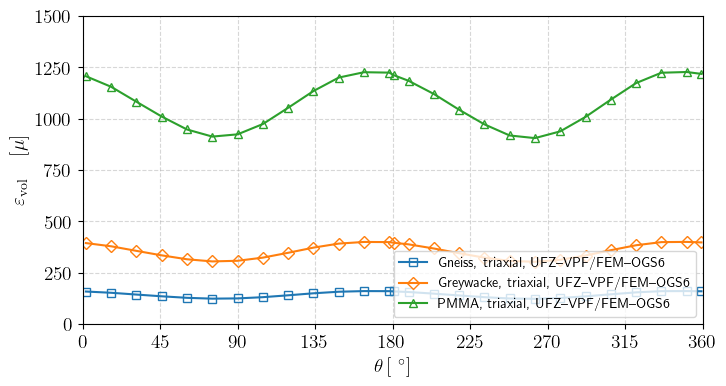

In [872]:
fig = plt.figure(figsize=(8, 4))  
ax = fig.add_subplot(1, 1, 1)
overall_counter = 0  
for material_index, (material_name, material_properties) in enumerate(materials.items(), start=1):
    enhanced_material_properties = material_properties.copy()  
    enhanced_material_properties['material_name'] = material_name
    enhanced_material_properties['material_index'] = material_index
    for load_index, (load_name, load_values) in enumerate(loads.items(), start=0):
        overall_counter += 1  
        print(f"Processing combination {overall_counter}: Material {material_index} ({material_name}), Load {load_index} ({load_name})")

#         run_benchmark('M1_triaxial', mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
        postproc_benchmark('M1_triaxial', load_name, fracture_angle, enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain='vol')

    
plt.grid(linestyle='dashed')
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.ylim([0, 1500])
plt.xlim([0, 360])
plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$', fontsize=14)
plt.xlabel(r'$\theta \left[~^{\circ} \right]$', fontsize=14)
legend_ = ax.legend(loc='lower right')
plt.show()



# Axisymmetric, Pristine Material

In [866]:
loads = {
    "Load_axisymmetric": [7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6,7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6]
 }

materials = {
    "Gneiss": {"young_sample": 83.9e9, "nu_sample": 0.21},
    "Greywacke": {"young_sample": 26.87e9, "nu_sample": 0.27},
    "PMMA": {"young_sample": 3.85e9, "nu_sample": 0.4},
}


legend_labels_all = ['Axisymmetric, UFZ--VPF/FEM--OGS6']


Processing combination 1: Material 1 (Gneiss), Load 0 (Load_axisymmetric)
The mesh folder added in prj file and modified successfully. Modified file saved to _out/great_cell_3d_SDprocess.prj
OGS Path: ~/master_test/build_master_modifiedE/bin/ogs, PRJ File: great_cell_3d_SDprocess.prj
mesh_0
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  43.12  s.
Processing combination 2: Material 2 (Greywacke), Load 0 (Load_axisymmetric)
The mesh folder added in prj file and modified successfully. Modified file saved to _out/great_cell_3d_SDprocess.prj
OGS Path: ~/master_test/build_master_modifiedE/bin/ogs, PRJ File: great_cell_3d_SDprocess.prj
mesh_0
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  46.45  s.
Processing combination 3: Material 3 (PMMA), Load 0 (Load_axisymmetric)
The mesh folder added in prj file and modified successfully. Modified file saved to _out/great_cell

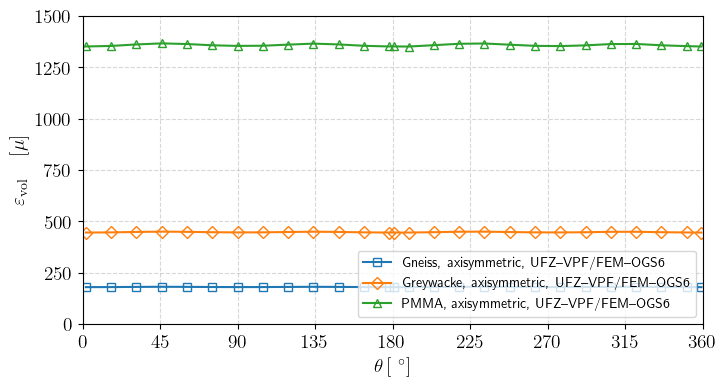

In [868]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)
overall_counter = 0  
for material_index, (material_name, material_properties) in enumerate(materials.items(), start=1):
    enhanced_material_properties = material_properties.copy()  
    enhanced_material_properties['material_name'] = material_name
    enhanced_material_properties['material_index'] = material_index
    for load_index, (load_name, load_values) in enumerate(loads.items(), start=0):
        overall_counter += 1  
        print(f"Processing combination {overall_counter}: Material {material_index} ({material_name}), Load {load_index} ({load_name})")

        run_benchmark('M1_axisymmetric', mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
        postproc_benchmark('M1_axisymmetric', load_name, fracture_angle, enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain='vol')

    
plt.grid(linestyle='dashed')
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.ylim([0, 1500])
plt.xlim([0, 360])
plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$', fontsize=14)
plt.xlabel(r'$\theta \left[~^{\circ} \right]$', fontsize=14)
legend_ = ax.legend(loc='lower right')
plt.show()

## Numerical Validation: A Comparative Study of Various Groups' Simulations Against Laboratory Experimental Data

### Data

In [876]:
#----------------------------------------------------------------------------------------------------
#UFZ--VPF/FEM--OGS6
#----------------------------------------------------------------------------------------------------
angles_vol_UFZ_tri, strain_vol_UFZ_tri = get_vol_strain(f'{results_dir}/results_M1_triaxial_Load_triaxial_0_PMMA')
strain_vol_UFZ_flipped_tri = np.insert(np.flip(strain_vol_UFZ_tri[1:]),0, strain_vol_UFZ_tri[0])

angles_surf_UFZ_tri, strain_surf_UFZ_tri = get_surf_strain(f'{results_dir}/results_M1_triaxial_Load_triaxial_0_PMMA')
strain_surf_UFZ_flipped_tri = np.insert(np.flip(strain_surf_UFZ_tri[1:]),0, strain_surf_UFZ_tri[0])


angles_vol_UFZ_elip_axisym, strain_vol_UFZ_elip_axisym = get_vol_strain(f'{results_dir}/results_M1_axisymmetric_Load_axisymmetric_0_PMMA')
strain_vol_UFZ_elip_flipped_axisym = np.insert(np.flip(strain_vol_UFZ_elip_axisym[1:]),0, strain_vol_UFZ_elip_axisym[0])

angles_surf_UFZ_elip_axisym, strain_surf_UFZ_elip_axisym = get_surf_strain(f'{results_dir}/results_M1_axisymmetric_Load_axisymmetric_0_PMMA')
strain_surf_UFZ_elip_flipped_axisym = np.insert(np.flip(strain_surf_UFZ_elip_axisym[1:]),0, strain_surf_UFZ_elip_axisym[0])

#----------------------------------------------------------------------------------------------------
#UFZ--VPF/FEM--OGS5
#----------------------------------------------------------------------------------------------------
df = pd.read_excel(r'./Data/DerivationofdataforFigure6McDermottetal2018.xlsx')
strain_surf_ogs5 = np.array(df['Unnamed: 36'][85:101])
angles_ogs5 = np.array(df['Unnamed: 34'][85:101])

strain_surf_ogs5_T2 = np.array(df['Unnamed: 36'][66:82])
angles_ogs5_T2 = np.array(df['Unnamed: 34'][66:82])

#----------------------------------------------------------------------------------------------------
#KAERI--IFDM/DEM--3DEC/TOUGH2
#----------------------------------------------------------------------------------------------------
# surface strain KAERI
kaeri_1=np.genfromtxt('./Data/Step1aSolidbodystraindata_KAERI.txt',usecols=(0,1))[3:50] #kaeri_1[:,0],kaeri_1[:,1] = angles, strain
kaeri_2=np.genfromtxt('./Data/Step1aSolidbodystraindata_KAERI.txt',usecols=(0,1))[53:100]

# volumetric strain kaeri
df = pd.read_excel(r'./Data/Task1_M1_volumetric_KAERI.xlsx')
angles_kaeri = np.array(df['LS1'][1:])
strain_vol_kaeri = np.array(df['Unnamed: 4'][1:])

angles_kaeri = np.array(df['LS1'][1:])
strain_vol_kaeri_T2 = np.array(df['Unnamed: 1'][1:])

#----------------------------------------------------------------------------------------------------
#CAS--hCA-FEM/xFEM--CASRock
#----------------------------------------------------------------------------------------------------
# surface strain CAS chinese academic of science
df = pd.read_excel(r'./Data/TaskGGREATCellResults-M-CASTeam.xlsx')
angles_CAS = np.array(df['Reference McDermott et al. 2018, figure 6'][8:])
strain_surf_CAS = np.array(df['Unnamed: 11'][8:])
#strain_surf_CAS_flipped = np.flip(strain_surf_CAS)

angles_CAS_T2 = np.array(df['Reference McDermott et al. 2018, figure 6'][8:])
strain_surf_CAS_T2 = np.array(df['Unnamed: 5'][8:])
#strain_surf_CAS_T2_flipped = np.flip(strain_surf_CAS_T2)

#----------------------------------------------------------------------------------------------------
#SNL--FEM--COMSOL
#----------------------------------------------------------------------------------------------------
# volumetric COMSOL
df = pd.read_excel(r'./Data/M1solidbodystrainmodelingresults_COMSOL_SNL_Rev1_Aug_30_23.xlsx')
angles_COMSOL =np.array(df['M1 -True Triaxial Case'][1:])
strain_vol_COMSOL = np.array(df['Unnamed: 2'][1:])

df = pd.read_excel(r'./Data/M1solidbodystrainmodelingresults_COMSOL_SNL_Rev1_Aug_30_23.xlsx', sheet_name='Axisymmetric_model')
angles_COMSOL_T2 =np.array(df['M1 -Axisymmetric Case'][1:])
strain_vol_COMSOL_T2 = np.array(df['Unnamed: 2'][1:])

#----------------------------------------------------------------------------------------------------
# UOE--Laboratory experimen
#----------------------------------------------------------------------------------------------------
df = pd.read_excel(r'./Data/DerivationofdataforFigure6McDermottetal2018.xlsx')
strain_surf_exp = np.array(df['Unnamed: 43'][28:44])
angles_exp = np.array(df['Unnamed: 42'][28:44])

strain_surf_exp_T2 = np.array(df['Unnamed: 43'][46:62])
angles_exp_T2 = np.array(df['Unnamed: 42'][46:62])

In [877]:
colors = ['#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7', '#000000']
markers = ['o', 's', 'd', '*', 'o','s']

### Mechanical tri-axial comparison

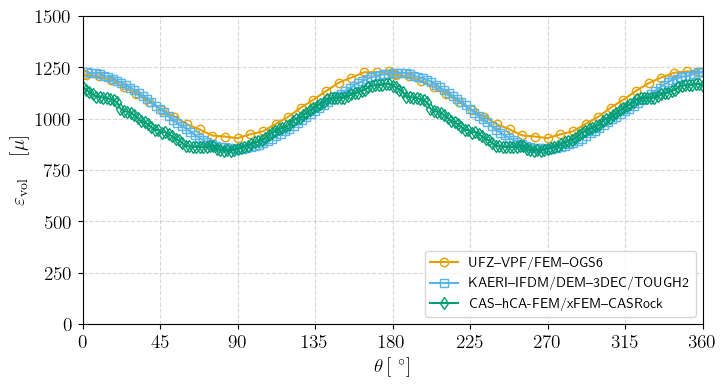

In [878]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_vol_UFZ_tri*180/math.pi,strain_vol_UFZ_flipped_tri*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(angles_kaeri,strain_vol_kaeri,  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_CAS,strain_surf_CAS,  marker=markers[2],fillstyle='none', color=colors[2], label='CAS--hCA-FEM/xFEM--CASRock')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{vol}} \quad \left[\mathrm{\mu}\right]$',fontsize =14) 
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)                
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/volstrain_M1_3D_tri.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

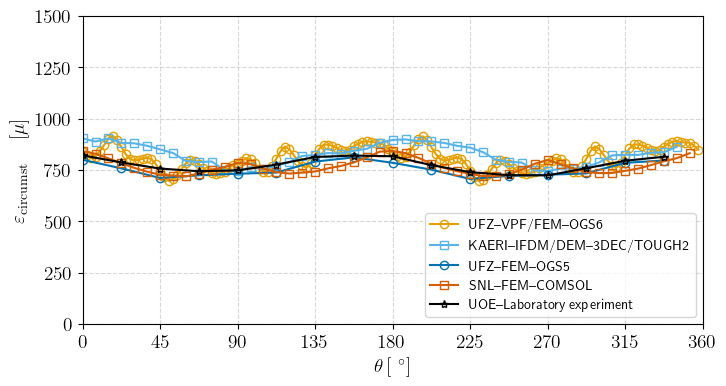

In [879]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_surf_UFZ_tri*180/math.pi,strain_surf_UFZ_flipped_tri*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(kaeri_1[:,0],kaeri_1[:,1],  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_ogs5,strain_surf_ogs5,  marker=markers[4],fillstyle='none', color=colors[4], label='UFZ--FEM--OGS5')
plt.plot(angles_COMSOL,strain_vol_COMSOL,  marker=markers[5],fillstyle='none', color=colors[5], label='SNL--FEM--COMSOL')
plt.plot(angles_exp,strain_surf_exp,  marker=markers[3],fillstyle='none', color='black', label='UOE--Laboratory experiment')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis   
plt.ylim([0,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{circumst}} \quad \left[\mathrm{\mu}\right]$',fontsize =14) 
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
# legend_ = ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/surfacestrain_M1_3D_tri.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

### Mechanical axisymmetric comparison

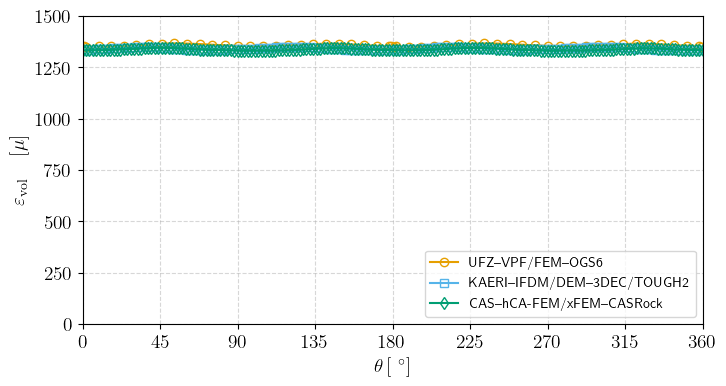

In [880]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_vol_UFZ_elip_axisym*180/math.pi,strain_vol_UFZ_elip_flipped_axisym*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(angles_kaeri,strain_vol_kaeri_T2,  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_CAS_T2,strain_surf_CAS_T2,  marker=markers[2],fillstyle='none', color=colors[2], label='CAS--hCA-FEM/xFEM--CASRock')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14) 
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/volstrain_M1_3D_axi.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

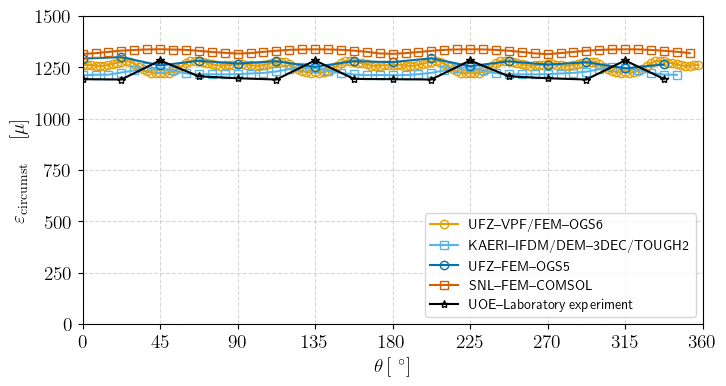

In [881]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_surf_UFZ_elip_axisym*180/math.pi,strain_surf_UFZ_elip_axisym*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(kaeri_2[:,0],kaeri_2[:,1],  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_ogs5_T2,strain_surf_ogs5_T2,  marker=markers[4],fillstyle='none', color=colors[4], label='UFZ--FEM--OGS5')
plt.plot(angles_COMSOL_T2,strain_vol_COMSOL_T2,  marker=markers[5],fillstyle='none', color=colors[5], label='SNL--FEM--COMSOL')
plt.plot(angles_exp_T2,strain_surf_exp_T2,  marker=markers[3],fillstyle='none', color='black', label='UOE--Laboratory experiment')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{circumst}} \quad \left[\mathrm{\mu}\right]$',fontsize =14)               
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/surfacestrain_M1_3D_axi.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

# Fractured samples (one and two wings cracks), Rotateable Loading

In [885]:
fracture_angle = 0
mesh_path = 'mesh_0'

The mesh folder added in prj file and modified successfully. Modified file saved to _out/great_cell_3d.prj
OGS Path: ~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs, PRJ File: great_cell_3d.prj
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  198.36  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  216.37  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  209.5  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  202.73  s.


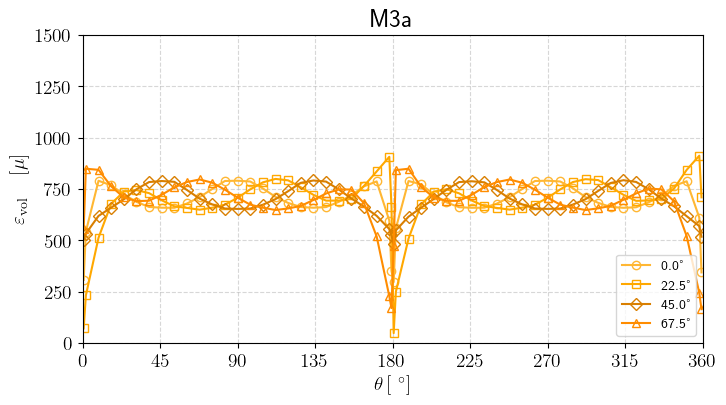

In [891]:
run_benchmark('M3a',  mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
postproc_benchmark('M3a', load_name, fracture_angle,  enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain = 'vol')

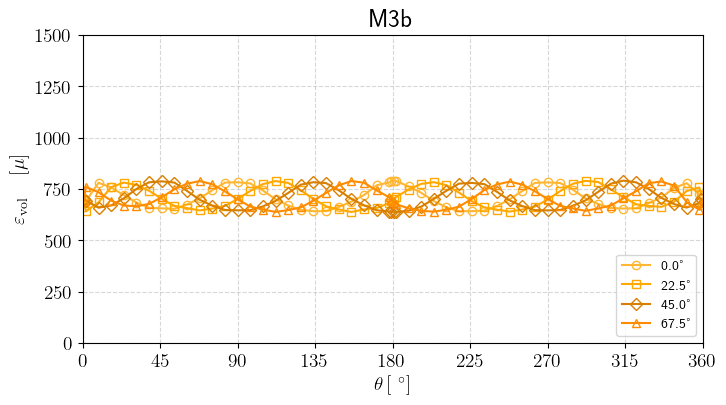

In [887]:
# run_benchmark('M3b',  mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
postproc_benchmark('M3b', load_name, fracture_angle,  enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain = 'vol')

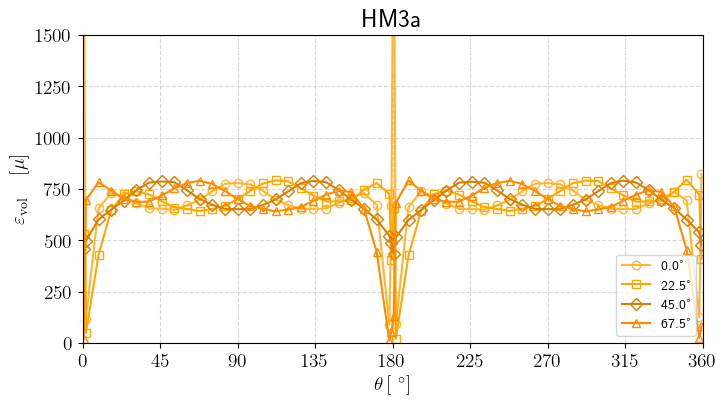

In [888]:
# run_benchmark('HM3a',  mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
postproc_benchmark('HM3a', load_name, fracture_angle,  enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain = 'vol')

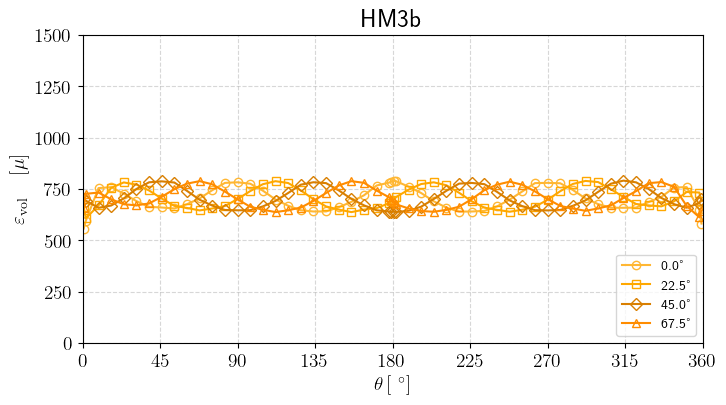

In [889]:
# run_benchmark('HM3b',  mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
postproc_benchmark('HM3b', load_name, fracture_angle,  enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain = 'vol')

# Fractured samples (one and two wings cracks), Chris's Loading

# Fracture angle 78.75

In [826]:
fracture_angle = 78.75
mesh_path = 'mesh_fullcrack_78.75'

In [827]:
loads = {
    "Load_0": [8.8e6, 8.8e6, 9.2e6, 9.0e6, 8.9e6, 8.7e6, 9.3e6, 8.7e6, 8.8e6, 8.8e6, 9.2e6, 9.0e6, 8.9e6, 8.7e6, 9.3e6, 8.7e6],
    "Load_1": [7.1e6, 6.3e6, 6.3e6, 6.9e6, 7.9e6, 8.7e6, 8.8e6, 7.8e6, 7.1e6, 6.3e6, 6.3e6, 6.9e6, 7.9e6, 8.7e6, 8.8e6, 7.8e6],
    "Load_2": [7.7e6, 8.7e6, 8.7e6, 7.7e6, 7.3e6, 6.3e6, 6.3e6, 6.6e6, 7.7e6, 8.7e6, 8.7e6, 7.7e6, 7.3e6, 6.3e6, 6.3e6, 6.6e6],
    "Load_3": [7.2e6, 8.2e6, 8.7e6, 8.7e6, 7.8e6, 6.8e6, 6.3e6, 6.2e6, 7.2e6, 8.2e6, 8.7e6, 8.7e6, 7.8e6, 6.8e6, 6.3e6, 6.2e6],
    "Load_4": [6.2e6, 7.2e6, 8.3e6, 8.7e6, 8.7e6, 7.7e6, 6.9e6, 6.3e6, 6.2e6, 7.2e6, 8.3e6, 8.7e6, 8.7e6, 7.7e6, 6.9e6, 6.3e6],
    "Load_5": [6.2e6, 6.2e6, 7.3e6, 8.1e6, 8.7e6, 8.7e6, 7.8e6, 6.7e6, 6.2e6, 6.2e6, 7.3e6, 8.1e6, 8.7e6, 8.7e6, 7.8e6, 6.7e6],
    "Load_6": [6.8e6, 6.4e6, 6.9e6, 7.5e6, 8.2e6, 8.7e6, 8.3e6, 7.2e6, 6.8e6, 6.4e6, 6.9e6, 7.5e6, 8.2e6, 8.7e6, 8.3e6, 7.2e6]
}


legend_labels_all = ["UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2=\sigma_3$",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, -56.25°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 33.75°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 56.25°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 78.75°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, -11.25°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 67.5°",
]

materials = {
    "PMMA": {"young_sample": 3.85e9, "nu_sample": 0.4},
}


## Two wings crack 

Processing combination 1: Material 1 (PMMA), Load 0 (Load_0)
Processing combination 2: Material 1 (PMMA), Load 1 (Load_1)
Processing combination 3: Material 1 (PMMA), Load 2 (Load_2)
Processing combination 4: Material 1 (PMMA), Load 3 (Load_3)
Processing combination 5: Material 1 (PMMA), Load 4 (Load_4)
Processing combination 6: Material 1 (PMMA), Load 5 (Load_5)
Processing combination 7: Material 1 (PMMA), Load 6 (Load_6)


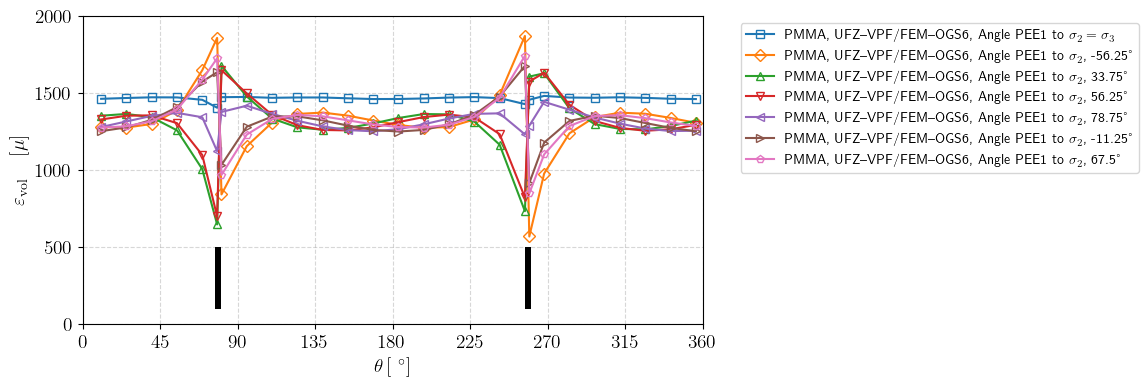

In [838]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)
overall_counter = 0  
for material_index, (material_name, material_properties) in enumerate(materials.items(), start=1):
    enhanced_material_properties = material_properties.copy()  
    enhanced_material_properties['material_name'] = material_name
    enhanced_material_properties['material_index'] = material_index
    for load_index, (load_name, load_values) in enumerate(loads.items(), start=0):
        overall_counter += 1  
        print(f"Processing combination {overall_counter}: Material {material_index} ({material_name}), Load {load_index} ({load_name})")

        #run_benchmark('M3a_triaxial', mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
        postproc_benchmark('M3a_triaxial', load_name, fracture_angle, enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain='vol')

        plt.vlines(fracture_angle, ymin=100, ymax=500, colors='black', linestyles='solid', linewidth=4)
        plt.vlines(fracture_angle + 180, ymin=100, ymax=500, colors='black', linestyles='solid', linewidth=4) 
        
plt.grid(linestyle='dashed')
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.ylim([0, 2000])
plt.xlim([0, 360])
plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$', fontsize=14)
plt.xlabel(r'$\theta \left[~^{\circ} \right]$', fontsize=14)
legend_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# One wing crack 

### Experimental results 

In [801]:
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = {}
    current_zone = None

    for line in lines:
        line = line.strip()
        if line.startswith('ZONE T='):
            current_zone = line.split('"')[1]
            data[current_zone] = {'Results_Angle': [], 'Surface_strain': []}
        elif not line.startswith('TITLE=') and not line.startswith('VARIABLES='):
            parts = line.split()
            if len(parts) >= 3:
                try:
                    angle = float(parts[1])
                    strain = float(parts[2])
                    data[current_zone]['Results_Angle'].append(angle)
                    data[current_zone]['Surface_strain'].append(strain)
                except ValueError:
                    print(f"Issue with line: {line}")

    return data

In [802]:
file_path = './Data/FF1_results_decovalex.txt'  # Replace with your file path
zone_data = read_data(file_path)

Issue with line: Comment Angles given clockwise positive from sx
Issue with line: VARIABLES ="Location" "Results_Angle" "Surface_strain" "STD"
Issue with line: VARIABLES ="Location" "Results_Angle" "Surface_strain" "STD"
Issue with line: VARIABLES ="Location" "Results_Angle" "Surface_strain" "STD"
Issue with line: VARIABLES ="Location" "Results_Angle" "Surface_strain" "STD"
Issue with line: VARIABLES ="Location" "Results_Angle" "Surface_strain" "STD"
Issue with line: VARIABLES ="Location" "Results_Angle" "Surface_strain" "STD"
Issue with line: VARIABLES ="Location" "Results_Angle" "Surface_strain" "STD"


## 

Processing combination 1: Material 1 (PMMA), Load 0 (Load_0)
Processing combination 2: Material 1 (PMMA), Load 1 (Load_1)
Processing combination 3: Material 1 (PMMA), Load 2 (Load_2)
Processing combination 4: Material 1 (PMMA), Load 3 (Load_3)
Processing combination 5: Material 1 (PMMA), Load 4 (Load_4)
Processing combination 6: Material 1 (PMMA), Load 5 (Load_5)
Processing combination 7: Material 1 (PMMA), Load 6 (Load_6)


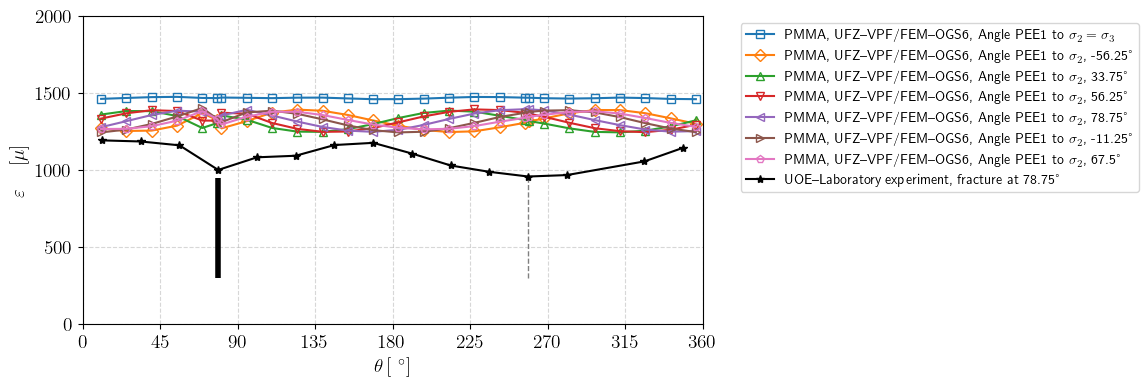

In [839]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)


overall_counter = 0  
for material_index, (material_name, material_properties) in enumerate(materials.items(), start=1):
    enhanced_material_properties = material_properties.copy()  
    enhanced_material_properties['material_name'] = material_name
    enhanced_material_properties['material_index'] = material_index
    for load_index, (load_name, load_values) in enumerate(loads.items(), start=0):
        overall_counter += 1  
        print(f"Processing combination {overall_counter}: Material {material_index} ({material_name}), Load {load_index} ({load_name})")

#         run_benchmark('M3b_triaxial', mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
        postproc_benchmark('M3b_triaxial', load_name, fracture_angle, enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain='vol')

plt.vlines(fracture_angle, ymin=300, ymax=950, colors='black', linestyles='solid', linewidth=4)
plt.vlines(fracture_angle + 180, ymin=300, ymax=950, colors='gray', linestyles='dashed', linewidth=1)     

# Experimental results
if fracture_angle == 112.5:
        for zone, data in zone_data.items():
            if zone == '500s sx to facture 112.5 Compression test':
                legendName = 'UOE--Laboratory experiment, fracture  at 112.5°'
                plt.plot(data['Results_Angle'], data['Surface_strain'], marker='*', color='k', label=legendName)

elif   fracture_angle == 78.75: 
        for zone, data in zone_data.items():
            if zone == 'Eliptical_750s sx to fracture 78.75 double bag loading':
                legendName = 'UOE--Laboratory experiment, fracture  at 78.75°'
                plt.plot(data['Results_Angle'], data['Surface_strain'], marker='*', color='k', label=legendName)
        
else :    
        print(f'{fracture_angle} is not a valid post processing option. Chose one of ["112.5", "78.75"]')
         
plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,2000])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{} \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
# legend_ = ax.legend(loc='lower right')
legend_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()  

# Fracture angle 112.5

In [840]:
fracture_angle = 112.5
mesh_path = 'mesh_fullcrack_112.5'

In [841]:
loads = {
    "Load_0": [8.8e6, 8.8e6, 9.2e6, 9.0e6, 8.9e6, 8.7e6, 9.3e6, 8.7e6, 8.8e6, 8.8e6, 9.2e6, 9.0e6, 8.9e6, 8.7e6, 9.3e6, 8.7e6],
    "Load_1": [7.1e6, 6.3e6, 6.3e6, 6.9e6, 7.9e6, 8.7e6, 8.8e6, 7.8e6, 7.1e6, 6.3e6, 6.3e6, 6.9e6, 7.9e6, 8.7e6, 8.8e6, 7.8e6],
    "Load_2": [7.7e6, 8.7e6, 8.7e6, 7.7e6, 7.3e6, 6.3e6, 6.3e6, 6.6e6, 7.7e6, 8.7e6, 8.7e6, 7.7e6, 7.3e6, 6.3e6, 6.3e6, 6.6e6],
    "Load_3": [7.2e6, 8.2e6, 8.7e6, 8.7e6, 7.8e6, 6.8e6, 6.3e6, 6.2e6, 7.2e6, 8.2e6, 8.7e6, 8.7e6, 7.8e6, 6.8e6, 6.3e6, 6.2e6],
    "Load_4": [6.2e6, 7.2e6, 8.3e6, 8.7e6, 8.7e6, 7.7e6, 6.9e6, 6.3e6, 6.2e6, 7.2e6, 8.3e6, 8.7e6, 8.7e6, 7.7e6, 6.9e6, 6.3e6],
    "Load_5": [6.2e6, 6.2e6, 7.3e6, 8.1e6, 8.7e6, 8.7e6, 7.8e6, 6.7e6, 6.2e6, 6.2e6, 7.3e6, 8.1e6, 8.7e6, 8.7e6, 7.8e6, 6.7e6],
    "Load_6": [6.8e6, 6.4e6, 6.9e6, 7.5e6, 8.2e6, 8.7e6, 8.3e6, 7.2e6, 6.8e6, 6.4e6, 6.9e6, 7.5e6, 8.2e6, 8.7e6, 8.3e6, 7.2e6]
}

materials = {
    "PMMA": {"young_sample": 3.85e9, "nu_sample": 0.4},
}


legend_labels_all = ["UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2=\sigma_3$",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, -56.25°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 33.75°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 56.25°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 78.75°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, -11.25°",
                     "UFZ--VPF/FEM--OGS6, Angle PEE1 to $\sigma_2$, 67.5°",
]


## Two wings crack

Processing combination 1: Material 1 (PMMA), Load 0 (Load_0)
Processing combination 2: Material 1 (PMMA), Load 1 (Load_1)
Processing combination 3: Material 1 (PMMA), Load 2 (Load_2)
Processing combination 4: Material 1 (PMMA), Load 3 (Load_3)
Processing combination 5: Material 1 (PMMA), Load 4 (Load_4)
Processing combination 6: Material 1 (PMMA), Load 5 (Load_5)
Processing combination 7: Material 1 (PMMA), Load 6 (Load_6)


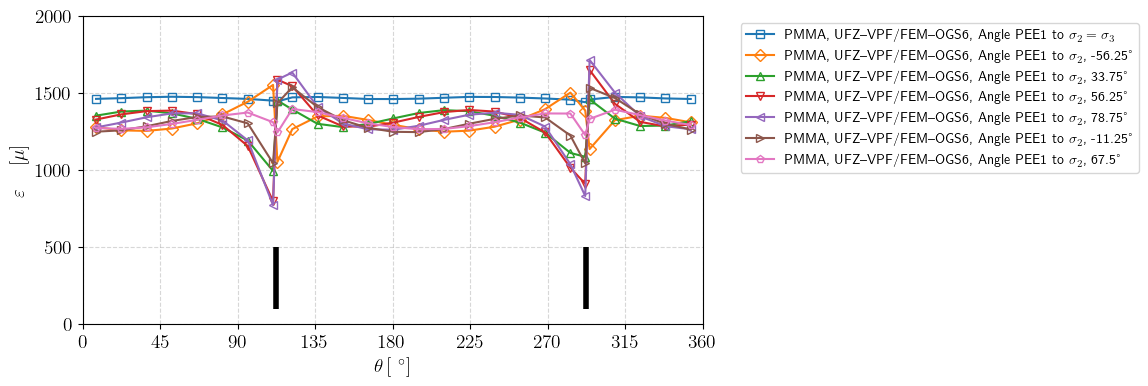

In [843]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)


overall_counter = 0  
for material_index, (material_name, material_properties) in enumerate(materials.items(), start=1):
    enhanced_material_properties = material_properties.copy()  
    enhanced_material_properties['material_name'] = material_name
    enhanced_material_properties['material_index'] = material_index
    for load_index, (load_name, load_values) in enumerate(loads.items(), start=0):
        overall_counter += 1  
        print(f"Processing combination {overall_counter}: Material {material_index} ({material_name}), Load {load_index} ({load_name})")

#         run_benchmark('M3a_triaxial', mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
        postproc_benchmark('M3a_triaxial', load_name, fracture_angle, enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain='vol')
    

plt.vlines(fracture_angle, ymin=100, ymax=500, colors='black', linestyles='solid', linewidth=4)
plt.vlines(fracture_angle + 180, ymin=100, ymax=500, colors='black', linestyles='solid', linewidth=4)

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,2000])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{} \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
# legend_ = ax.legend(loc='lower right')
legend_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()  

# One wing crack

Processing combination 1: Material 1 (PMMA), Load 0 (Load_0)
Processing combination 2: Material 1 (PMMA), Load 1 (Load_1)
Processing combination 3: Material 1 (PMMA), Load 2 (Load_2)
Processing combination 4: Material 1 (PMMA), Load 3 (Load_3)
Processing combination 5: Material 1 (PMMA), Load 4 (Load_4)
Processing combination 6: Material 1 (PMMA), Load 5 (Load_5)
Processing combination 7: Material 1 (PMMA), Load 6 (Load_6)


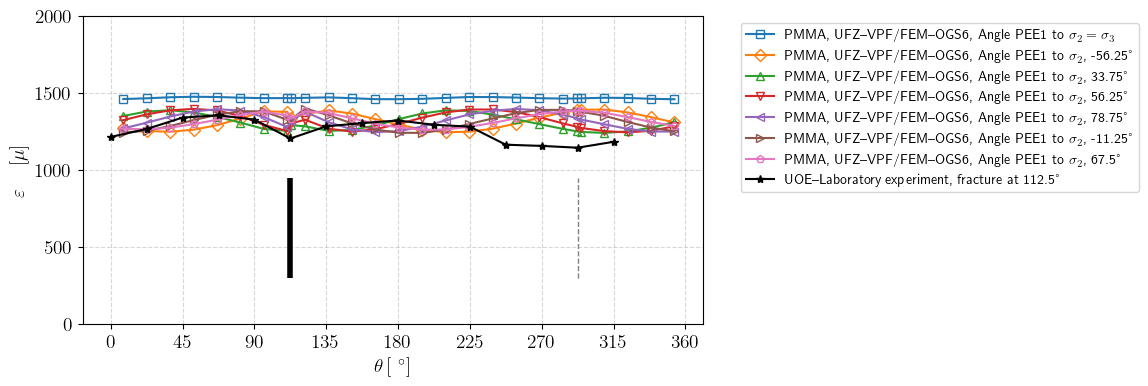

In [844]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

overall_counter = 0  
for material_index, (material_name, material_properties) in enumerate(materials.items(), start=1):
    enhanced_material_properties = material_properties.copy()  
    enhanced_material_properties['material_name'] = material_name
    enhanced_material_properties['material_index'] = material_index
    for load_index, (load_name, load_values) in enumerate(loads.items(), start=0):
        overall_counter += 1  
        print(f"Processing combination {overall_counter}: Material {material_index} ({material_name}), Load {load_index} ({load_name})")

#         run_benchmark('M3b_triaxial', mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
        postproc_benchmark('M3b_triaxial', load_name, fracture_angle, enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain='vol')
    
    
plt.vlines(fracture_angle, ymin=300, ymax=950, colors='black', linestyles='solid', linewidth=4)
plt.vlines(fracture_angle + 180, ymin=300, ymax=950, colors='gray', linestyles='dashed', linewidth=1)


# Experimental results
if fracture_angle == 112.5:
        for zone, data in zone_data.items():
            if zone == '500s sx to facture 112.5 Compression test':
                legendName = 'UOE--Laboratory experiment, fracture  at 112.5°'
                plt.plot(data['Results_Angle'], data['Surface_strain'], marker='*', color='k', label=legendName)

elif   fracture_angle == 78.75: 
        for zone, data in zone_data.items():
            if zone == 'Eliptical_750s sx to fracture 78.75 double bag loading':
                legendName = 'UOE--Laboratory experiment, fracture  at 78.75°'
                plt.plot(data['Results_Angle'], data['Surface_strain'], marker='*', color='k', label=legendName)
        
else :    
        print(f'{fracture_angle} is not a valid post processing option. Chose one of ["112.5", "78.75"]')

        
plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,2000])
# plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{} \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
# legend_ = ax.legend(loc='lower right')
legend_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()  

# Fracture angle 0

# one wing crack

In [848]:
fracture_angle = 0
mesh_path = 'mesh_0'

In [849]:
loads = {
    "Load_triaxial": [7.73e6, 5.7e6, 4.39e6, 2.4e6, 2.3e6, 4e6, 6.4e6, 7.7e6, 7.73e6, 5.7e6, 4.39e6, 2.4e6, 2.3e6, 4e6, 6.4e6, 7.7e6],
    "Load_axisymmetric": [7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6,7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6]
}

materials = {
    "PMMA": {"young_sample": 3.85e9, "nu_sample": 0.4},
}


legend_labels_all = ["UFZ--VPF/FEM--OGS6, True-Triaxial",
                     "UFZ--VPF/FEM--OGS6, Axisymmetric"]


### KAERI's results

In [814]:
#----------------------------------------------------------------------------------------------------
#KAERI--IFDM/DEM--3DEC/TOUGH2
#----------------------------------------------------------------------------------------------------
df_KAERI_vol = pd.read_excel(r'./Data/Results_M2.xlsx', sheet_name='vol_strain', usecols='A:C', skiprows=range(1, 1))
df_KAERI_vol.columns = ['theta', 'strain_axi_vol', 'strain_tri_vol']  

df_KAERI_circ = pd.read_excel(r'./Data/Results_M2.xlsx', sheet_name='circ_strain', usecols='A:C', skiprows=range(1, 1))
df_KAERI_circ.columns = ['theta', 'strain_axi_circ', 'strain_tri_circ']  

Processing combination 1: Material 1 (Gneiss), Load 0 (Load_triaxial)


FileNotFoundError: File (/Users/mollaali/Decovalex2023/GreatCell_benchmark/3D/_out/results_M3b_triaxial_Load_triaxial_0_Gneiss/GreatCell_3D_ts_4_t_4.000000.vtu) not found

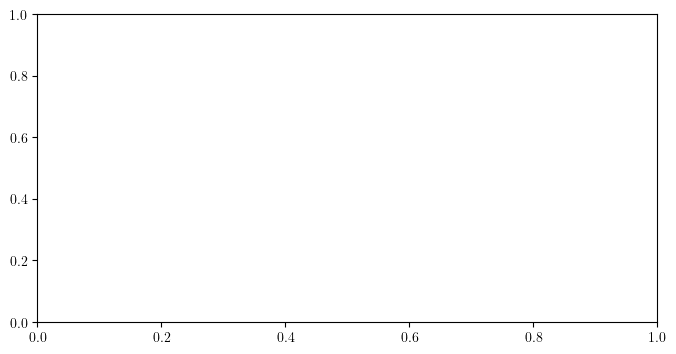

In [892]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

overall_counter = 0  
for material_index, (material_name, material_properties) in enumerate(materials.items(), start=1):
    enhanced_material_properties = material_properties.copy()  
    enhanced_material_properties['material_name'] = material_name
    enhanced_material_properties['material_index'] = material_index
    for load_index, (load_name, load_values) in enumerate(loads.items(), start=0):
        overall_counter += 1  
        print(f"Processing combination {overall_counter}: Material {material_index} ({material_name}), Load {load_index} ({load_name})")

#         run_benchmark('M3b_triaxial', mesh_path, load_values, load_name, fracture_angle, enhanced_material_properties)
        postproc_benchmark('M3b_triaxial', load_name, fracture_angle, enhanced_material_properties, overall_counter, legend_labels_all[load_index], strain='vol')
    
    
plt.vlines(fracture_angle, ymin=300, ymax=950, colors='black', linestyles='solid', linewidth=4)
plt.vlines(fracture_angle + 180, ymin=300, ymax=950, colors='gray', linestyles='dashed', linewidth=1)


plt.plot(df_KAERI_vol['theta'], df_KAERI_vol['strain_axi_vol'],  marker='S',fillstyle='none', color=colors[0], label='PMMA, KAERI--IFDM/DEM--3DEC/TOUGH2, Axisymmetric')
plt.plot(df_KAERI_vol['theta'], df_KAERI_vol['strain_tri_vol'],  marker='D',fillstyle='none', color=colors[1], label='PMMA, KAERI--IFDM/DEM--3DEC/TOUGH2, True-Triaxial')
        
        
plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,2000])
# plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{} \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
# legend_ = ax.legend(loc='lower right')
legend_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()  

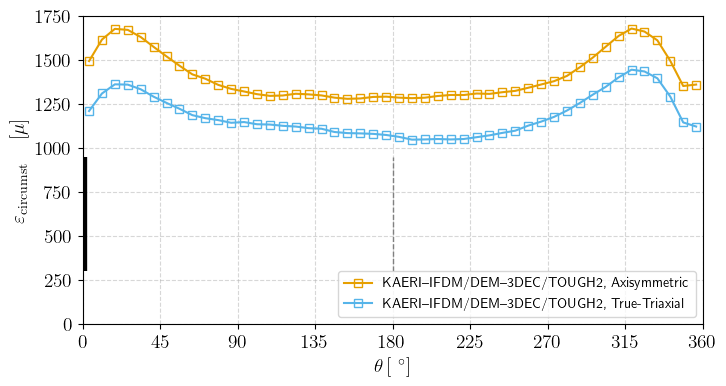

In [816]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

# Plot the data
plt.plot(df_KAERI_circ['theta'], df_KAERI_circ['strain_axi_circ'],  marker=markers[1],fillstyle='none', color=colors[0], label='KAERI--IFDM/DEM--3DEC/TOUGH2, Axisymmetric')
plt.plot(df_KAERI_circ['theta'], df_KAERI_circ['strain_tri_circ'],  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2, True-Triaxial')

plt.vlines(0, ymin=300, ymax=950, colors='black', linestyles='solid', linewidth=6)
plt.vlines(0 + 180, ymin=300, ymax=950, colors='gray', linestyles='dashed', linewidth=1)

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,1750])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{circumst}} \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
legend_ = ax.legend(loc='lower right')
plt.show()